In [1]:
import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

strava_export = "c:\\Users\\matti\\Desktop\\Garmin IQ datafield\\export_105647830\\activities"

import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

In [19]:
###########################################
####### GET DATA COMPUTED BY STRAVA #######
###########################################

activities_df = pd.read_csv(strava_export + ".csv")
activities_df["Filename"] = activities_df["Filename"].apply(lambda v: v if pd.isnull(v)
                                                            else v.split("/")[1].replace(".gz", ""))

```python
#######################
### UNZIP ALL FILES ###
#######################
for filename in os.listdir(strava_export):
    if filename.endswith('.gz') and filename.replace(".gz", "") not in os.listdir(strava_export): 
    print(filename)
    with gzip.open("\\".join((strava_export, filename)), 'rb') as f_in:
        with open("\\".join((strava_export, filename))[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
```

In [3]:
list_of_fit_files = ["\\".join((strava_export, v)) for v in os.listdir(strava_export)
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((strava_export, v)) for v in os.listdir(strava_export)
                     if ".gpx" in v]

In [4]:
##########################################
### GET TO DATAFRAME PER EACH FIT FILE ###
##########################################
list_of_dfs_fit_points = []
list_of_dfs_fit_laps = []
for file in tqdm(list_of_fit_files):
    d_ = parse_fit.get_dataframes(file)
    list_of_dfs_fit_laps.append(d_[0])
    list_of_dfs_fit_points.append(d_[1])

fit_file_laps = pd.concat(list_of_dfs_fit_laps, ignore_index = True)
fit_file_points = pd.concat(list_of_dfs_fit_points, ignore_index = True)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [09:16<00:00,  4.75s/it]
C:\Users\matti\AppData\Local\Temp\ipykernel_18792\4025744445.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_file_laps = pd.concat(list_of_dfs_fit_laps, ignore_index = True)
C:\Users\matti\AppData\Local\Temp\ipykernel_18792\4025744445.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_file_points = pd.concat(list_of_dfs_fit_points, ignore_index = True)


In [32]:
fit_file_points = fit_file_points.merge(activities_df, left_on = "FileName", right_on = "Filename", how = "left")
fit_file_laps = fit_file_laps.merge(activities_df, left_on = "FileName", right_on = "Filename", how = "left")

In [38]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps.to_parquet(".\\data\\fit_file_laps.parquet")
fit_file_points.to_parquet(".\\data\\fit_file_points.parquet")

In [194]:
[d for d in list_of_dfs_fit_points
 if d[["altitude", "cadence", "calories", "distance",
       "speed", "grade", "heart_rate", "temperature"]].isnull().sum().sum()/len(d)*8 < 0.05][6]

,FileName,latitude,longitude,lap,altitude,cadence,calories,compressed_speed_distance,cycle_length,distance,enhanced_altitude,enhanced_speed,grade,heart_rate,position_lat,position_long,power,resistance,speed,temperature,time_from_course,timestamp
0,10710188514.fit,45.462326,9.132765,1,NaN,NaN,0,NaN,NaN,0.00,NaN,0.000,0.0,NaN,542386674,108958136,NaN,NaN,0.000,24,NaN,2023-10-07 06:18:44+00:00
1,10710188514.fit,45.462325,9.132768,1,NaN,NaN,0,NaN,NaN,0.00,NaN,0.000,0.0,93.0,542386662,108958172,NaN,NaN,0.000,24,NaN,2023-10-07 06:18:45+00:00
2,10710188514.fit,45.462307,9.132850,1,NaN,0.0,0,NaN,NaN,0.31,NaN,0.725,0.0,88.0,542386445,108959150,NaN,NaN,0.725,24,NaN,2023-10-07 06:19:00+00:00
3,10710188514.fit,45.462308,9.132862,1,NaN,0.0,0,NaN,NaN,0.31,NaN,0.000,0.0,89.0,542386459,108959287,NaN,NaN,0.000,24,NaN,2023-10-07 06:19:01+00:00
4,10710188514.fit,45.462309,9.132871,1,NaN,0.0,0,NaN,NaN,0.31,NaN,0.000,0.0,90.0,542386479,108959393,NaN,NaN,0.000,24,NaN,2023-10-07 06:19:02+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26660,10710188514.fit,45.462622,9.132907,5,120.8,0.0,5183,NaN,NaN,143115.43,120.8,2.086,0.0,113.0,542390203,108959830,NaN,NaN,2.086,26,NaN,2023-10-07 16:20:08+00:00
26661,10710188514.fit,45.462604,9.132901,5,120.8,0.0,5183,NaN,NaN,143117.41,120.8,1.961,0.0,113.0,542389998,108959751,NaN,NaN,1.961,26,NaN,2023-10-07 16:20:09+00:00
26662,10710188514.fit,45.462584,9.132896,5,120.8,0.0,5183,NaN,NaN,143119.76,120.8,2.697,0.0,114.0,542389750,108959695,NaN,NaN,2.697,26,NaN,2023-10-07 16:20:10+00:00
26663,10710188514.fit,45.462559,9.132893,5,120.8,0.0,5183,NaN,NaN,143122.50,120.8,2.902,0.0,114.0,542389457,108959659,NaN,NaN,2.902,26,NaN,2023-10-07 16:20:11+00:00


In [47]:
sorted(activities_df["Activity Name"])[::-1][:10]

['Zwift - Zwift Academy: Workout 1 | Explosive 30s in Yorkshire',
 'Zwift - Zwift Academy Tri:  Bike Workout 2 | Aerobic Threshold Development in Watopia',
 'Zwift - Zone 3 Steps in Makuri Islands',
 'Zwift - Zone 1 Ride in Innsbruck',
 'Zwift - Workout 13 in New York',
 'Zwift - Volcano Climb Forward in Watopia',
 'Zwift - Triple Flat Loops in Watopia',
 'Zwift - Tiny Race: Seaside Sprint in Watopia',
 'Zwift - Threshold Development in France',
 'Zwift - Threshold #2 in Watopia']

In [90]:
# activities_df[activities_df["Activity Name"] == "Back to salite in real life"] # Zwift - The Pretzel in Watopia
activities_df[activities_df["Activity Name"] == "Zwift - The Pretzel in Watopia"] # 

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Private Note,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Average Flow,Flagged,Average Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
132,11659433168,"Jun 15, 2024, 1:19:44 PM",Zwift - The Pretzel in Watopia,Virtual Ride,Ride to improve PBs on hills,11086,73.07,186.0,202.0,False,NaN,Scott Addict RC (virtual),12441011297.fit,NaN,7.9,11086.0,10407.0,73076.007812,24.015625,7.021813,1354.0,0.0,-6.4,516.200012,19.785538,-0.007937,NaN,NaN,114.0,87.526077,186.0,157.124146,NaN,144.016159,1431.0,NaN,NaN,202.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,155.0,10660.0,0.0,274.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13940951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.591738,0.0,NaN,NaN,NaN,NaN,NaN,NaN,219.0,86.0,NaN,NaN,NaN,media/c67ff196-d530-4e92-a210-242434894968.jpg...


In [50]:
sorted(activities_df["Activity Name"])[:20]

['30 km indoor ride',
 '30km indoor',
 '40 km indoor ride',
 '45 km indoor ride',
 '45 km indoor ride',
 '5km run 💀',
 'A spasso day 2',
 'Abbazia di Rosazzo',
 'Affezionato alla Brianza + giro turistico in centro',
 'Afternoon Ride',
 'Afternoon Ride - All4Cycling',
 'Afternoon Ride in the rain🌧',
 'Allenamento #1',
 'Almeno la foratura questo giro è arrivata vicino casa',
 'Attorno a San Siro prima della UCL',
 'Azzardando ghiaini a Teolo',
 'Back in Veneto',
 'Back on the road',
 'Back to salite in real life',
 'Berico-Giaretta-Sasso']

In [77]:
# fit_file_points[fit_file_points["grade"].notna()]

In [220]:
# find slope
x = fit_file_points[fit_file_points["Filename"] == "12441011297.fit"].copy()
x = x.reset_index(drop = True)

In [221]:
x.head()

,FileName,latitude,longitude,lap,altitude,cadence,calories,compressed_speed_distance,cycle_length,distance,enhanced_altitude,enhanced_speed,grade,heart_rate,position_lat,position_long,power,resistance,speed,temperature,time_from_course,timestamp,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Private Note,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,...,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Average Flow,Flagged,Average Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
0,12441011297.fit,-11.639474,166.948264,1,7.4,0.0,NaN,None,None,2.46,7.4,2.371,NaN,104.0,-138864336,1991770368,0.0,NaN,NaN,None,None,2024-06-15 13:19:44+00:00,11659433168,"Jun 15, 2024, 1:19:44 PM",Zwift - The Pretzel in Watopia,Virtual Ride,Ride to improve PBs on hills,11086,73.07,186.0,202.0,False,NaN,Scott Addict RC (virtual),12441011297.fit,NaN,7.9,11086.0,10407.0,73076.007812,24.015625,7.021813,1354.0,0.0,-6.4,516.200012,19.785538,-0.007937,NaN,NaN,...,NaN,NaN,155.0,10660.0,0.0,274.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13940951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.591738,0.0,NaN,NaN,NaN,NaN,NaN,NaN,219.0,86.0,NaN,NaN,NaN,media/c67ff196-d530-4e92-a210-242434894968.jpg...
1,12441011297.fit,-11.639455,166.948274,1,7.2,48.0,NaN,None,None,5.15,7.2,3.145,NaN,102.0,-138864112,1991770496,237.0,NaN,NaN,None,None,2024-06-15 13:19:45+00:00,11659433168,"Jun 15, 2024, 1:19:44 PM",Zwift - The Pretzel in Watopia,Virtual Ride,Ride to improve PBs on hills,11086,73.07,186.0,202.0,False,NaN,Scott Addict RC (virtual),12441011297.fit,NaN,7.9,11086.0,10407.0,73076.007812,24.015625,7.021813,1354.0,0.0,-6.4,516.200012,19.785538,-0.007937,NaN,NaN,...,NaN,NaN,155.0,10660.0,0.0,274.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13940951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.591738,0.0,NaN,NaN,NaN,NaN,NaN,NaN,219.0,86.0,NaN,NaN,NaN,media/c67ff196-d530-4e92-a210-242434894968.jpg...
2,12441011297.fit,-11.639433,166.948307,1,7.2,60.0,NaN,None,None,8.82,7.2,3.940,NaN,101.0,-138863840,1991770880,110.0,NaN,NaN,None,None,2024-06-15 13:19:46+00:00,11659433168,"Jun 15, 2024, 1:19:44 PM",Zwift - The Pretzel in Watopia,Virtual Ride,Ride to improve PBs on hills,11086,73.07,186.0,202.0,False,NaN,Scott Addict RC (virtual),12441011297.fit,NaN,7.9,11086.0,10407.0,73076.007812,24.015625,7.021813,1354.0,0.0,-6.4,516.200012,19.785538,-0.007937,NaN,NaN,...,NaN,NaN,155.0,10660.0,0.0,274.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13940951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.591738,0.0,NaN,NaN,NaN,NaN,NaN,NaN,219.0,86.0,NaN,NaN,NaN,media/c67ff196-d530-4e92-a210-242434894968.jpg...
3,12441011297.fit,-11.639408,166.948339,1,7.0,60.0,NaN,None,None,12.82,7.0,4.580,NaN,101.0,-138863552,1991771264,116.0,NaN,NaN,None,None,2024-06-15 13:19:47+00:00,11659433168,"Jun 15, 2024, 1:19:44 PM",Zwift - The Pretzel in Watopia,Virtual Ride,Ride to improve PBs on hills,11086,73.07,186.0,202.0,False,NaN,Scott Addict RC (virtual),12441011297.fit,NaN,7.9,11086.0,10407.0,73076.007812,24.0156

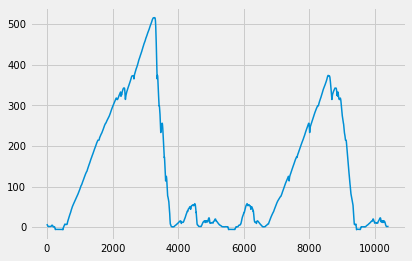

In [222]:
plt.plot(x["altitude"])

In [123]:
(100*(x["altitude"].diff().fillna(0.01)/(x["distance"].diff().fillna(0.001) + 0.01))).describe()

count     26665.000000
mean         18.394678
std        2129.609152
min      -10000.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      342000.000000
dtype: float64

In [118]:
fit_file_points[fit_file_points["grade"].notna()][["FileName", "Activity Name", "distance", "altitude"]].dropna(how = "any")[["FileName", "Activity Name"]].drop_duplicates()

,FileName,Activity Name
24,10057687651.fit,Day 1: Verso Asti
21586,10057691840.fit,Day 2: Monferrato
39156,10112528019.fit,Morning Ride
45291,10193450347.fit,Unico giro sotto i 100 km con salite da Milano?
60372,10327150072.fit,Affezionato alla Brianza + giro turistico in c...
76748,10527301818.fit,Long time no see Brianza
89198,10710188514.fit,IL LOMBARDIA 2023
115858,10755123838.fit,Se fori fori nel punto più lontano da casa
140438,10876234942.fit,In paradiso day 1
149777,10876244654.fit,A spasso day 2


In [227]:
x.isnull().sum()[:25]

FileName                         0
latitude                         0
longitude                        0
lap                              0
altitude                         0
cadence                          0
calories                     10414
compressed_speed_distance    10414
cycle_length                 10414
distance                         0
enhanced_altitude                0
enhanced_speed                   0
grade                        10414
heart_rate                       0
position_lat                     0
position_long                    0
power                            0
resistance                   10414
speed                        10414
temperature                  10414
time_from_course             10414
timestamp                        0
Activity ID                      0
Activity Date                    0
Activity Name                    0
dtype: int64

In [231]:
(3.6*x["enhanced_speed"]).mean()

25.24964121375072

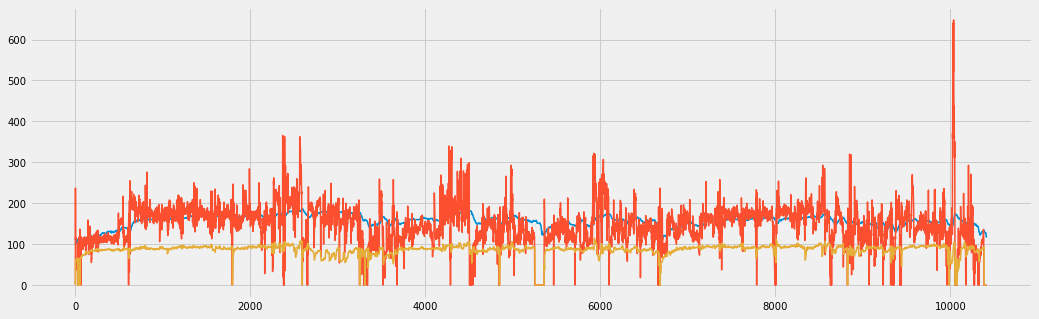

In [237]:
plt.figure(figsize = (16, 5))
# plt.plot((3.6*x["enhanced_speed"]))
# plt.plot(x["enhanced_altitude"])
plt.plot(x["heart_rate"])
plt.plot(x["power"])
plt.plot(x["cadence"])

In [212]:
# Data manipulation
# ==============================================================================
from skforecast.datasets import fetch_dataset

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

Skforecast version:  0.12.1


In [154]:
x[x["speed"] > 0]["speed"].describe()*3.6

count    95043.600000
mean        19.185937
std          7.617514
min          2.008800
25%         13.957200
50%         20.448000
75%         24.447600
max         51.138000
Name: speed, dtype: float64

In [160]:
x["cadence"] = x["cadence"].fillna(0)
x["altitude"] = x["altitude"].bfill()
x["heart_rate"] = x["heart_rate"].bfill()

C:\Users\matti\AppData\Local\Temp\ipykernel_18792\1754506508.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x["altitude"] = x["altitude"].fillna(method = "bfill")


In [166]:
x[["cadence", "calories", "distance", "altitude", "grade", "heart_rate", "speed", "temperature"]].isnull().sum()

cadence        0
calories       0
distance       0
altitude       0
grade          0
heart_rate     0
speed          0
temperature    0
dtype: int64

In [282]:
feature_cols = ['altitude', 'cadence', 'distance',
                'enhanced_speed', 'heart_rate', 'power']

C:\Users\matti\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


<AxesSubplot:>

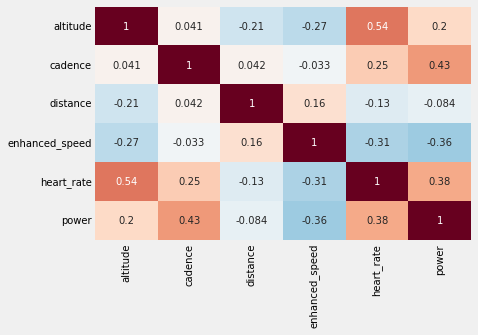

In [279]:
sns.heatmap(x[feature_cols].corr(), annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, cbar = False)

In [280]:
x.shape

(10414, 116)

Train dates : 0 --- 7413  (n=7414)
Test dates  : 7414 --- 10413  (n=3000)


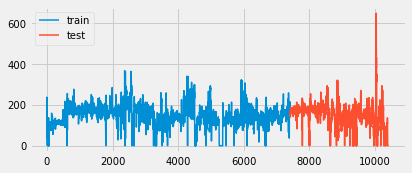

In [284]:
# Split data into train-test
# ==============================================================================
steps = 3000
data_train = x[feature_cols][:-steps]
data_test  = x[feature_cols][-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['power'].plot(ax=ax, label='train')
data_test['power'].plot(ax=ax, label='test')
ax.legend();

In [285]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123,
                                                   max_features = len(feature_cols) - 1,
                                                  n_jobs = -1),
                 lags      = 20
             )
forecaster.fit(y=data_train['power'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_features=5, n_jobs=-1, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 7413] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-07-09 22:59:15 
Last fit date: 2024-07-09 22:59:16 
Skforecast v

In [286]:
# Predictions
# ==============================================================================
steps = 5000
predictions = forecaster.predict(steps=steps)
predictions.head(5)

7414    185.24
7415    183.69
7416    183.42
7417    184.84
7418    185.12
Name: pred, dtype: float64

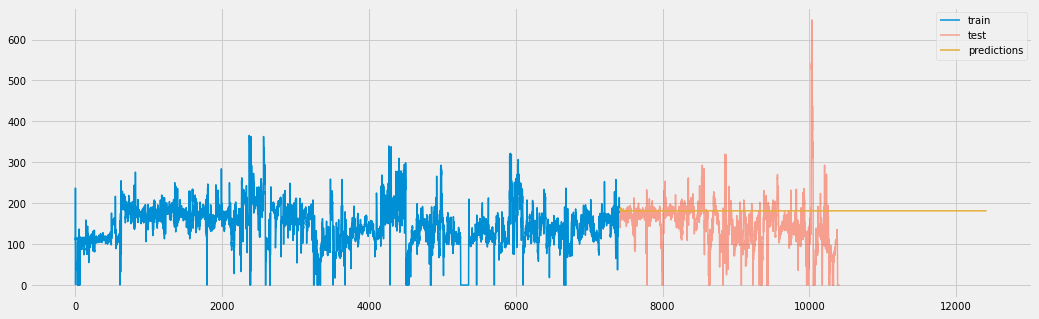

In [287]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 5))
data_train['power'].plot(ax=ax, label='train')
data_test['power'].plot(ax=ax, label='test', alpha = .5)
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [198]:
def preprocessing(lst):
    
    out = []
    for d in lst:
        if d["power"].isnull().sum() == 0:
            # print(d["FileName"].values[0])        
            dd = d.copy().reset_index(drop = True)
            dd["heart_rate"] = dd["heart_rate"].astype(int)
            dd["grade"] = (dd["altitude"].diff().fillna(0.01)/(dd["distance"].diff().fillna(0.01) + 0.1))
            dd.loc[dd["grade"] > 25,  "grade"] = 25
            dd.loc[dd["grade"] < -25, "grade"] = -25

            dd = dd.dropna(axis = 1, how = "all")
            dd = dd.sort_values("timestamp").reset_index(drop = True)

            dd_3s = dd.set_index("timestamp").drop("FileName", axis = 1).resample('3s', offset="0.1s",
                                                                                  origin = "start").mean()
            dd_3s = dd_3s.dropna(how = "all")
            dd_3s = dd_3s[dd_3s["power"] > 0].reset_index(drop = True)

            out += [dd_3s]
        
    return pd.concat(out, ignore_index = True)

In [69]:
# list_of_dfs_fit_points[0].head()

In [199]:
Xy = preprocessing(list_of_dfs_fit_points)

C:\Users\matti\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


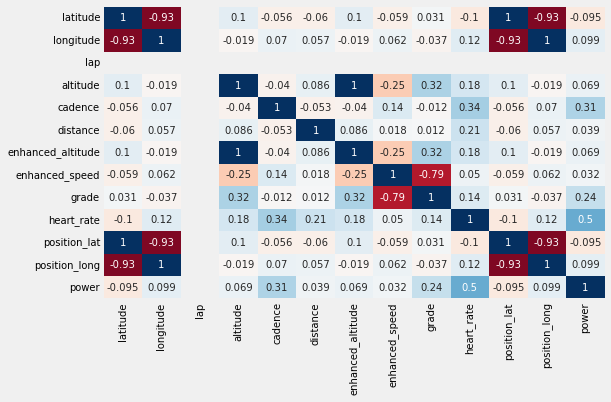

In [200]:
plt.figure(figsize = (8, 5))
sns.heatmap(Xy.corr(), vmin = -1, vmax = 1, cbar = False, annot = True, cmap = "RdBu")
plt.show()

In [201]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

X = Xy[["heart_rate", "enhanced_speed", "cadence", "grade"]].copy()
y = Xy["power"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print(lr.coef_, lr.intercept_)

[  0.88421898   5.02341121   0.59511101 569.45189369] -93.78712651747864


In [206]:
lr.predict(X_test)* (lr.predict(X_test) > 0)

array([141.4487973 , 101.62434774, 139.05610969, ..., 127.31703116,
       115.2108028 , 121.05792282])

In [207]:
lr_preds = pd.DataFrame({"y_true": y_test, "y_pred": lr.predict(X_test)* (lr.predict(X_test) > 0)})
lr_preds["delta"] = abs(lr_preds["y_true"] - lr_preds["y_pred"])

<AxesSubplot:>

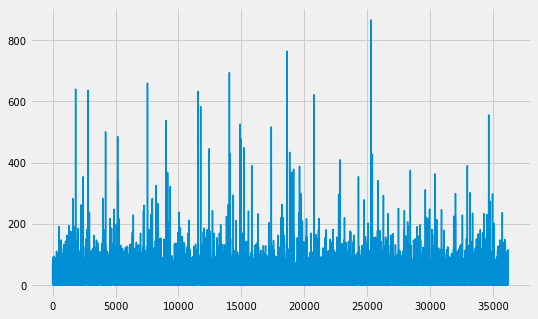

In [208]:
plt.figure(figsize = (8, 5))
lr_preds["delta"].reset_index(drop = True).plot()

<AxesSubplot:>

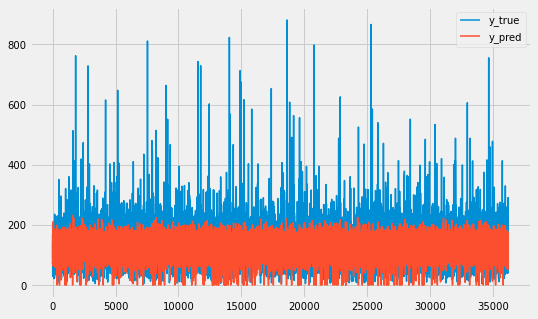

In [209]:
fix, ax = plt.subplots(1, 1, figsize = (8, 5))
lr_preds.reset_index(drop = True).drop("delta", axis = 1).plot(ax = ax)

In [213]:
print("R^2: {:.2f}".format(r2_score(y_test, lr.predict(X_test))))
print("RMSE: {:.2f}".format(root_mean_squared_error(y_test, lr.predict(X_test))))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, lr.predict(X_test))))
print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, lr.predict(X_test))))

R^2: 0.35
RMSE: 37.85
MAE: 24.10
MAPE: 24.87 %


In [214]:
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed

C:\Users\matti\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\matti\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\matti\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _TENSORSHAPEPROTO_

In [215]:
model = Sequential()
model.add(Dense(input_dim = 4, units = 4, activation = "elu"))
model.add(Dense(units = 4, activation = "elu"))
model.add(Dense(units = 4, activation = "elu"))
model.add(Dense(units = 1, activation = None))
model.compile(loss = "mean_absolute_error", optimizer = "adam",
              metrics = ["mean_absolute_error", "mean_absolute_percentage_error"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [216]:
## Define an Early Stopping
early_stopping = EarlyStopping(monitor = "mean_absolute_error", mode = "min", patience = 20, verbose = 1)

history = model.fit(X_train, y_train, epochs = 1000, batch_size = 100,
                    verbose = 0, validation_split = 0.4, callbacks = [early_stopping])

Epoch 94: early stopping


<AxesSubplot:>

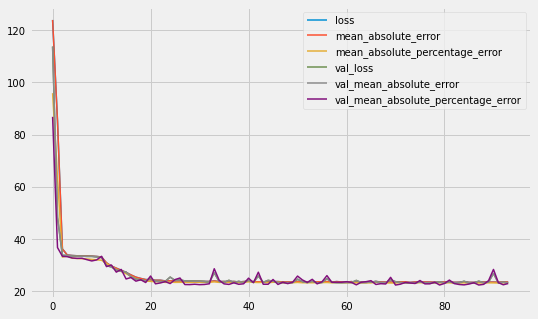

In [217]:
pd.DataFrame(history.history).plot(figsize = (8, 5))

In [219]:
print("RMSE: {:.2f}".format(root_mean_squared_error(y_test, model.predict(X_test))))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, model.predict(X_test))))
print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, model.predict(X_test))))

1132/1132 [==============================] - 1s 1ms/step
RMSE: 36.70
1132/1132 [==============================] - 1s 1ms/step
MAE: 22.97
1132/1132 [==============================] - 1s 1ms/step
MAPE: 22.74 %


$POWER=\frac{9\cdot(6\cdot A\cdot R-b\cdot c)}{26.46\cdot a}$

$R=$

$9^{\frac{1}{3}}$

$x=\frac{1}{1157360400a^3}*[\frac{}{50^{\frac{2}{3}}}-\frac{}{50^{\frac{1}{3}}}+11809799900\cdot a^3\cdot s^3+a^2\cdot b\cdot(11809799900\cdot s^2 - 3936600000\cdot c)+3936599980\cdot a\cdot b^2 \cdot s + 437399997\cdot b^3]$

```python
##########################################
### GET TO DATAFRAME PER EACH GPX FILE ###
##########################################

list_of_dfs_gpx = []
for file in list_of_gpx_files:
    try:
        d_ = parse_gpx.get_dataframe_from_gpx(file)
        list_of_dfs_gpx.append(d_)
    except Exception as e:
        print(file)

list_of_dfs_gpx[0]

from lxml.etree import tostring

gpx = gpxpy.parse(open("\\".join((strava_export, "7501129268.gpx")), 'r'))

print(len(gpx.tracks))
for track in gpx.tracks:
    print(len(track.segments))
    for segment in track.segments:
        print(len(segment.points))
        for point in segment.points:
            
            #print(point.attributes)

            print({'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation,
            'time': point.time,
            'speed': point.speed})
            # print(tostring(point.extensions[0]))
            # # for df in []:
            # #     print(elem.find(f'garmin_tpe:{df}', NAMESPACES).text)


            # NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}
            # print(point.extensions[0].find('garmin_tpe:speed', NAMESPACES).text)
```